In [1]:
# RUN THIS CELL
# import packages, check folders

#%reset
from pathlib import Path
import os
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import pickle

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
#print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook
#data_file_loc = os.getcwd()
data_file_loc

'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data'

In [88]:
# import Shen ROI labels for later plots
pd.set_option('display.max_colwidth', None) # so columns are not snipped

# loading the Shen atlas labels
shen268 = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
shen268.head()

,1,2,3,4,5,6,7,8,9,10,...,259,260,261,262,263,264,265,266,267,268
0,"{'coords': [14.083200000000005, 56.6944, -16.684799999999996], 'name': '92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex'}","{'coords': [9.599999999999994, 17.61882352941177, -19.53411764705882], 'name': '60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex'}","{'coords': [5.270633397312864, 35.03262955854126, -17.5278310940499], 'name': '58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex'}","{'coords': [15.647840531561457, 34.18604651162792, -22.544850498338867], 'name': '54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex'}","{'coords': [8.283887468030684, 46.05882352941177, -1.6700767263427139], 'name': '47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole'}","{'coords': [14.581460674157299, 64.75280898876406, 3.682584269662925], 'name': '100.00% Frontal_Pole'}","{'coords': [30.41914191419142, 54.79537953795381, -3.3267326732673297], 'name': '100.00% Frontal_Pole'}","{'coords': [44.469325153374236, 46.095092024539866, -4.917177914110425], 'name': '99.85% Frontal_Pole'}","{'coords': [28.814814814814817, 51.163163163163176, 18.73473473473473], 'name': '100.00% Frontal_Pole'}","{'coords': [8.521081081081078, 53.28, 23.885405405405407], 'name': '48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus'}",...,"{'coords': [-10.399527186761233, 10.877068557919614, -8.056737588652481], 'name': '20.66% Subcallosal_Cortex; 19.95% Left_Putamen; 19.83% Left_Accumbens; 14.40% Left_Caudate; 13.81% no_label; 5.67% Frontal_Orbital_Cortex'}","{'coords': [-14.491582491582491, -3.54882154882155, 20.909090909090907], 'name': '55.03% Left_Caudate; 29.53% Left_Lateral_Ventrical; 11.07% Left_Thalamus'}","{'coords': [-24.77079107505071, 5.537525354969574, -0.07302231237322587], 'name': '96.96% Left_Putamen'}","{'coords': [-9.427230046948353, -25.539906103286384, -1.3755868544600958], 'name': '72.56% Left_Thalamus; 21.40% Brain-Stem; 5.58% no_label'}","{'coords': [-4.68474576271187, -10.2406779661017, 5.877966101694909], 'name': '82.71% Left_Thalamus; 13.90% Left_Lateral_Ventrical'}","{'coords': [-11.407792207792212, -25.563636363636363, 14.883116883116884], 'name': '61.82% Left_Thalamus; 31.43% Left_Lateral_Ventrical'}","{'coords': [-4.821052631578951, -21.51157894736842, -15.890526315789472], 'name': '71.16% Brain-Stem; 25.89% no_label'}","{'coords': [-4.227272727272734, -37.89772727272728, -53.26704545454545], 'name': '100.00% Brain-Stem'}","{'coords': [-6.9375, -33.13068181818181, -39.34659090909091], 'name': '99.15% Brain-Stem'}","{'coords': [-5.697885196374628, -18.966767371601208, -36.81570996978852], 'name': '100.00% Brain-Stem'}"


# Trialwise normalization + smoothing (older)

In [66]:
# to load yes/no timecourses
def get_trial_timecourses_respbased():
    # returns timeourses and means of yes and no responders separately. dims (1049, 268, 28, 10)
    # doesn't take any inputs, but data_file_loc (location with responseinfo and movie timecourse) 
    # needs to be previously defined
    # Other info: 1. the 'responses' file has a mat of dims nsub*nmovies
    # 2. each movie timecourse file has the dims: nsub*nnodes*ntimepts(43)
    
    responses = np.load(os.path.join(data_file_loc,'responses_slopereg.npy')) # subs*movies
    nmovies = 10
    for movie_ind in range(nmovies):
        fileName = os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-movie{movie_ind}.npy')
        movieTC = np.load(fileName) # nsubs * nnodes * ntimepts
        movieTC = movieTC[:,:,:28]
        
        resp_yes = responses[:,movie_ind] == 1
        resp_no = responses[:,movie_ind] == 0
        resp_unsure = responses[:,movie_ind] == 9
        
        if movie_ind == 0:
            movie_tc_yes = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_no  = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_unsure  = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_yes[:] = np.nan
            movie_tc_no[:] = np.nan
            movie_tc_unsure[:] = np.nan
        
        movie_tc_yes[resp_yes,:,:,movie_ind] = movieTC[resp_yes,:,:] # fills out only yes rows
        movie_tc_no[resp_no,:,:,movie_ind] = movieTC[resp_no,:,:] # fills out only no rows
        movie_tc_unsure[resp_unsure,:,:,movie_ind] = movieTC[resp_unsure,:,:] # fills out only no rows
        # nsubs * nnodes * ntimepts * nmovies
    
    return movie_tc_yes, movie_tc_no, movie_tc_unsure

# creating the yes/no timecourse files of dim (1049, 268, 28, 10)
movie_tc_yes_trialwise, movie_tc_no_trialwise, movie_tc_unsure_trialwise = get_trial_timecourses_respbased()
movie_tc_unsure_trialwise.shape

(1049, 268, 28, 10)

59.84% Lingual_Gyrus
 28.82% Occipital_Fusiform_Gyrus
 11.34% Temporal_Occipital_Fusiform_Cortex 
-----
60.71% Occipital_Fusiform_Gyrus
 21.94% Lingual_Gyrus
 17.21% Occipital_Pole 
-----


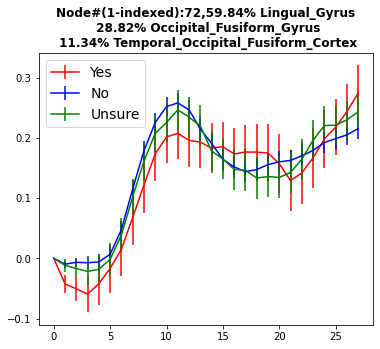

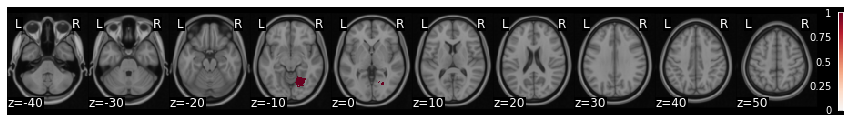

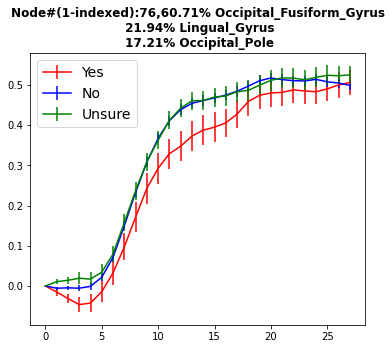

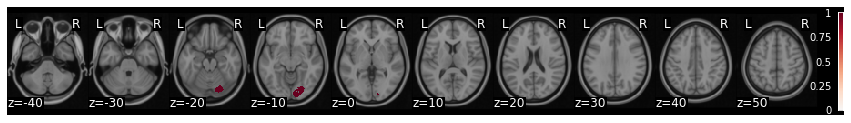

In [80]:
node = [71,75]
for i,node_ind in enumerate(nodes):
    #node_ind = 75
    movie_ind=4
    dict = eval(shen268[str(node_ind +1)][0])
    nodename =dict['name']
    nodename = nodename.split(';')
    nodename = "\n".join(nodename)
    print(nodename,'\n-----')


    plt.figure(i*2+1,figsize = (6,5))
    plt.errorbar(range(28),np.nanmean(movie_tc_yes_trialwise[:,node_ind,:,movie_ind],axis=0),
                 stats.sem(movie_tc_yes_trialwise[:,node_ind,:,movie_ind],axis=0,nan_policy='omit'),
                 color = 'r', label = 'Yes')
    plt.errorbar(range(28),np.nanmean(movie_tc_no_trialwise[:,node_ind,:,movie_ind],axis=0),
                 stats.sem(movie_tc_no_trialwise[:,node_ind,:,movie_ind],axis=0,nan_policy='omit')
                 ,color ='b', label = 'No')
    plt.errorbar(range(28),np.nanmean(movie_tc_unsure_trialwise[:,node_ind,:,movie_ind],axis=0),
                 stats.sem(movie_tc_unsure_trialwise[:,node_ind,:,movie_ind],axis=0,nan_policy='omit')
                 ,color ='g', label = 'Unsure')


    plt.title("Node#(1-indexed):"+str(node_ind+1)+','+nodename, fontweight = 'bold')
    plt.legend(fontsize = 14)



    mat = np.zeros((268,))
    mat[node_ind] = 1
    img = roi_to_brain(pd.Series(mat), mask_x) # plot max difference timepoint for each node
    # red/blue indicate whether yes>no or yes-no at that timept >0 or <0
    # intensity of red/blue indicate whether the activity was early or late 
    #(todo: change negative values in the colorbar)
    img.plot(colorbar=True, cmap = 'RdBu_r')





# Runwise Normalization, no smoothing (new preprocessing)

In [81]:
# to load yes/no timecourses
def get_trial_timecourses_respbased():
    # returns timeourses and means of yes and no responders separately. dims (1049, 268, 28, 10)
    # doesn't take any inputs, but data_file_loc (location with responseinfo and movie timecourse) 
    # needs to be previously defined
    # Other info: 1. the 'responses' file has a mat of dims nsub*nmovies
    # 2. each movie timecourse file has the dims: nsub*nnodes*ntimepts(43)
    
    responses = np.load(os.path.join(data_file_loc,'responses_slopereg.npy')) # subs*movies
    fileName = os.path.join(data_file_loc,'timecourses_run_norm',\
                            'timecourse-all-movies.npy')
    tc_all = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
    nmovies = 10
    
    for movie_ind in range(nmovies):
        movieTC = tc_all[:,:,:28,movie_ind]
        print(movieTC.shape)        
        resp_yes = responses[:,movie_ind] == 1
        resp_no = responses[:,movie_ind] == 0
        resp_unsure = responses[:,movie_ind] == 9
        
        if movie_ind == 0:
            movie_tc_yes = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_no  = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_unsure  = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_yes[:] = np.nan
            movie_tc_no[:] = np.nan
            movie_tc_unsure[:] = np.nan
        
        movie_tc_yes[resp_yes,:,:,movie_ind] = movieTC[resp_yes,:,:] # fills out only yes rows
        movie_tc_no[resp_no,:,:,movie_ind] = movieTC[resp_no,:,:] # fills out only no rows
        movie_tc_unsure[resp_unsure,:,:,movie_ind] = movieTC[resp_unsure,:,:] # fills out only no rows
        # nsubs * nnodes * ntimepts * nmovies
    
    return movie_tc_yes, movie_tc_no, movie_tc_unsure

# creating the yes/no timecourse files of dim (1049, 268, 28, 10)
movie_tc_yes, movie_tc_no, movie_tc_unsure = get_trial_timecourses_respbased()
movie_tc_unsure.shape

(1049, 268, 28)
(1049, 268, 28)
(1049, 268, 28)
(1049, 268, 28)
(1049, 268, 28)
(1049, 268, 28)
(1049, 268, 28)
(1049, 268, 28)
(1049, 268, 28)
(1049, 268, 28)


(1049, 268, 28, 10)

59.84% Lingual_Gyrus
 28.82% Occipital_Fusiform_Gyrus
 11.34% Temporal_Occipital_Fusiform_Cortex 
-----
60.71% Occipital_Fusiform_Gyrus
 21.94% Lingual_Gyrus
 17.21% Occipital_Pole 
-----


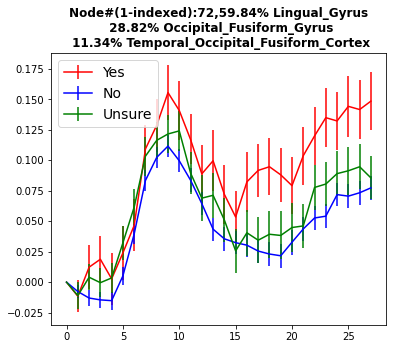

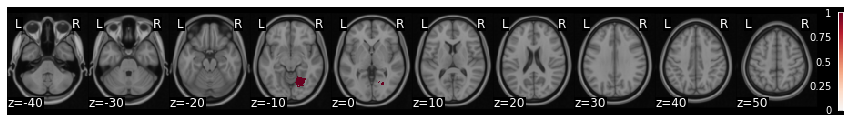

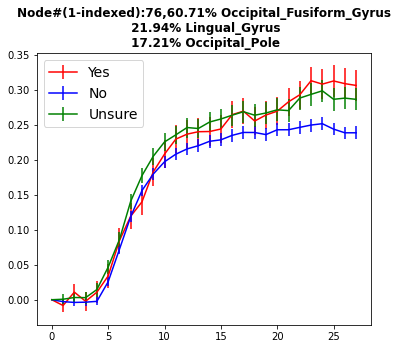

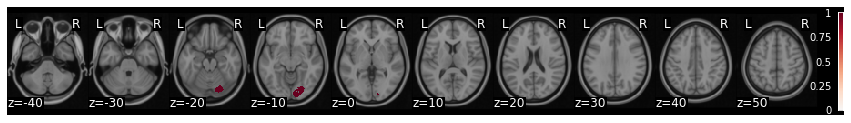

In [82]:
node = [71,75]
movie_ind=4
    

for i,node_ind in enumerate(nodes):
    #node_ind = 75
    dict = eval(shen268[str(node_ind +1)][0])
    nodename =dict['name']
    nodename = nodename.split(';')
    nodename = "\n".join(nodename)
    print(nodename,'\n-----')


    plt.figure(i*2+1,figsize = (6,5))
    plt.errorbar(range(28),np.nanmean(movie_tc_yes[:,node_ind,:,movie_ind],axis=0),
                 stats.sem(movie_tc_yes[:,node_ind,:,movie_ind],axis=0,nan_policy='omit'),
                 color = 'r', label = 'Yes')
    plt.errorbar(range(28),np.nanmean(movie_tc_no[:,node_ind,:,movie_ind],axis=0),
                 stats.sem(movie_tc_no[:,node_ind,:,movie_ind],axis=0,nan_policy='omit')
                 ,color ='b', label = 'No')
    plt.errorbar(range(28),np.nanmean(movie_tc_unsure[:,node_ind,:,movie_ind],axis=0),
                 stats.sem(movie_tc_unsure[:,node_ind,:,movie_ind],axis=0,nan_policy='omit')
                 ,color ='g', label = 'Unsure')


    plt.title("Node#(1-indexed):"+str(node_ind+1)+','+nodename, fontweight = 'bold')
    plt.legend(fontsize = 14)



    mat = np.zeros((268,))
    mat[node_ind] = 1
    img = roi_to_brain(pd.Series(mat), mask_x) # plot max difference timepoint for each node
    # red/blue indicate whether yes>no or yes-no at that timept >0 or <0
    # intensity of red/blue indicate whether the activity was early or late 
    #(todo: change negative values in the colorbar)
    img.plot(colorbar=True, cmap = 'RdBu_r')




Plotting the ROI below each timecourse...



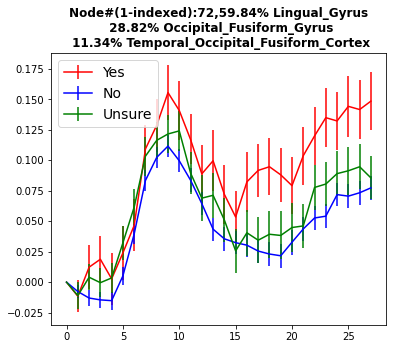

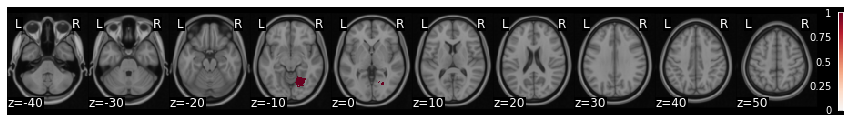

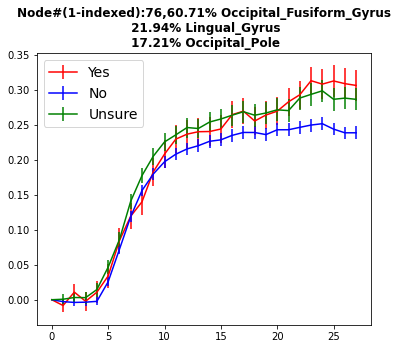

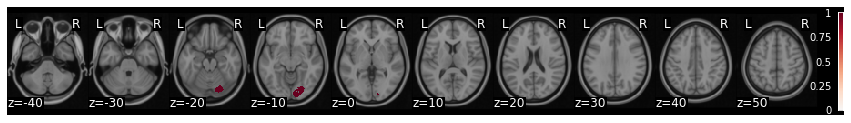

In [83]:
print('Plotting the ROI below each timecourse...\n')
nodes = [71,75]
for i,node_ind in enumerate(nodes):
    #node_ind = 75
    movie_ind=4
    dict = eval(shen268[str(node_ind +1)][0])
    nodename =dict['name']
    nodename = nodename.split(';')
    nodename = "\n".join(nodename)
    #print(nodename,'\n-----')


    plt.figure(i*2,figsize = (6,5))
    plt.errorbar(range(28),np.nanmean(movie_tc_yes[:,node_ind,:,movie_ind],axis=0),
                 stats.sem(movie_tc_yes[:,node_ind,:,movie_ind],axis=0,nan_policy='omit'),
                 color = 'r', label = 'Yes')
    plt.errorbar(range(28),np.nanmean(movie_tc_no[:,node_ind,:,movie_ind],axis=0),
                 stats.sem(movie_tc_no[:,node_ind,:,movie_ind],axis=0,nan_policy='omit')
                 ,color ='b', label = 'No')
    plt.errorbar(range(28),np.nanmean(movie_tc_unsure[:,node_ind,:,movie_ind],axis=0),
                 stats.sem(movie_tc_unsure[:,node_ind,:,movie_ind],axis=0,nan_policy='omit')
                 ,color ='g', label = 'Unsure')


    plt.title("Node#(1-indexed):"+str(node_ind+1)+','+nodename, fontweight = 'bold')
    plt.legend(fontsize = 14)



    mat = np.zeros((268,))
    mat[node_ind] = 1
    img = roi_to_brain(pd.Series(mat), mask_x) # plot max difference timepoint for each node
    # red/blue indicate whether yes>no or yes-no at that timept >0 or <0
    # intensity of red/blue indicate whether the activity was early or late 
    #(todo: change negative values in the colorbar)
    img.plot(colorbar=True, cmap = 'RdBu_r')





## More ROIs

In [89]:
# nodes with the earliest difference at TR < 4

'''nodes = np.array([  0,   1,   3,  18,  19,  20,  21,  22,  28,  31,  33,  36,  42,
        56,  63,  64,  71,  75,  79,  89,  96, 102, 103, 117, 127, 140,
       141, 158, 163, 177, 182, 186, 198, 205, 217, 219, 223, 224, 228,
       248, 262])

timepts_signed = np.array([-1., -2., -1., -2., -2., -2., -2., -1., -3., -3., -2., -1., -1.,
       -3., -2., -2., -2., -2., -2., -3., -4., -2., -1., -1., -4.,  4.,
        2., -2.,  1.,  1.,  1., -2., -3., -4., -4., -2., -4., -1.,  1.,
       -4., -3.])'''

nodes = np.array([0,   6,  15,  25,  41,  58,  65,  95, 119, 120, 125, 126, 127,
       129, 135, 148, 150, 158, 165, 169, 188, 189, 194, 203, 204, 206,
       215, 233, 249, 260])

timepts_signed = np.array([-1., -2., -1., -1., -4., -1.,  1., -1., -4., -2.,  2., -1., -3.,
       -1., -1.,  1.,  1.,  2.,  2., -3., -2.,  4.,  1.,  3., -2.,  4.,
       -1., -2., -4., -1.])

filter_ = ((nodes>40) & (nodes<90)) | ((nodes>200) & (nodes<215)) 
# filtering roughly to get posterior/visual nodes
nodes = nodes[filter_]
timepts_signed = timepts_signed[filter_]


dict1 = ["" for x in range(len(nodes))]
for i,n in enumerate(nodes):
    dict1[i] = eval(shen268[str(n +1)][0])['name']
    #print(n,dict1,'\n')
    
df = pd.DataFrame({'nodes(0-267):':nodes,'timepts':timepts_signed,'labels': dict1})
df.head(50)

,nodes(0-267):,timepts,labels
0,41,-4.0,80.25% Precuneous_Cortex; 11.39% Cuneal_Cortex; 8.19% Lateral_Occipital_Cortex_superior_division
1,58,-1.0,54.08% Inferior_Temporal_Gyrus_posterior_division; 45.92% Temporal_Fusiform_Cortex_posterior_division
2,65,1.0,35.14% Inferior_Temporal_Gyrus_temporooccipital_part; 29.73% Lateral_Occipital_Cortex_inferior_division; 27.48% Temporal_Occipital_Fusiform_Cortex; 7.66% Occipital_Fusiform_Gyrus
3,203,3.0,46.71% Lateral_Occipital_Cortex_superior_division; 32.88% Occipital_Pole; 20.40% Lateral_Occipital_Cortex_inferior_division
4,204,-2.0,52.42% Lingual_Gyrus; 17.53% Precuneous_Cortex; 13.69% Cingulate_Gyrus_posterior_division; 9.52% Left_Lateral_Ventrical
5,206,4.0,39.92% Occipital_Fusiform_Gyrus; 36.69% Temporal_Occipital_Fusiform_Cortex; 23.39% Lingual_Gyrus


plotting more nodes..

Node nr. 1-indexed


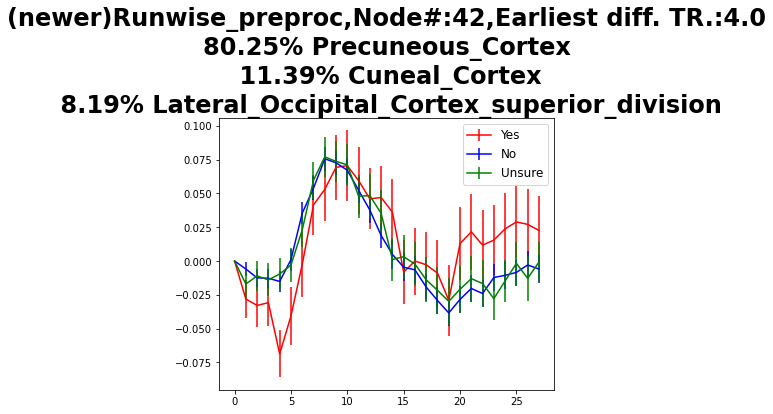

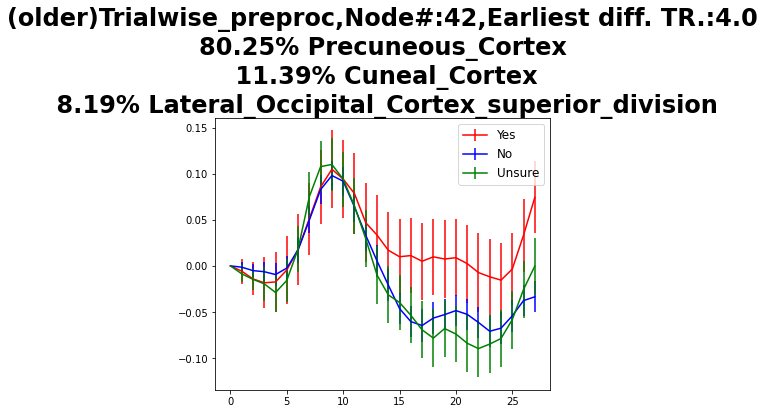

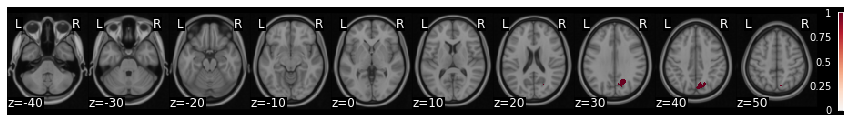

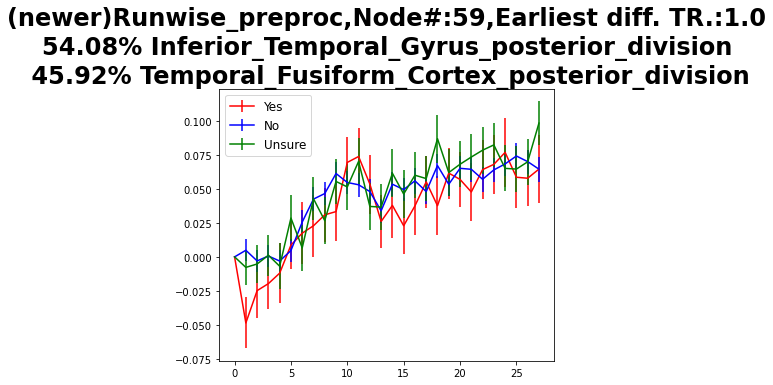

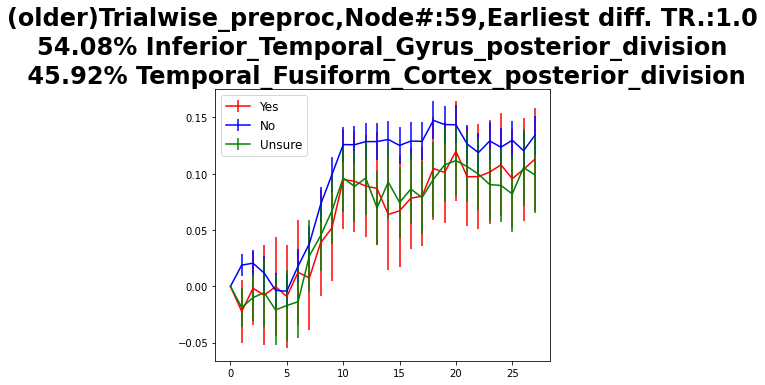

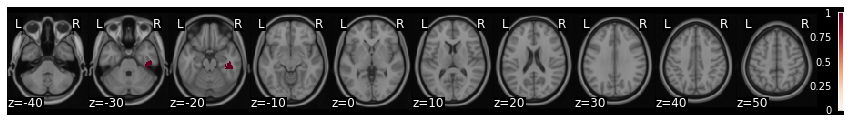

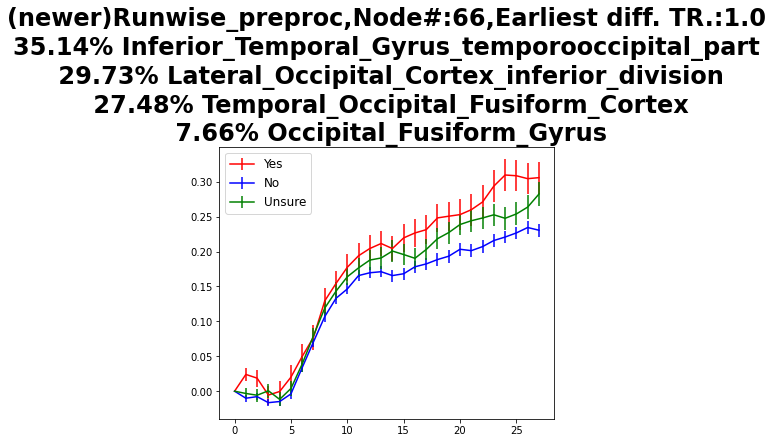

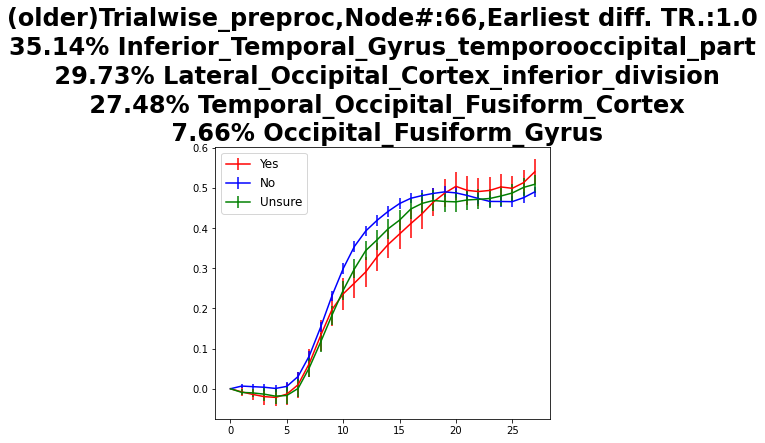

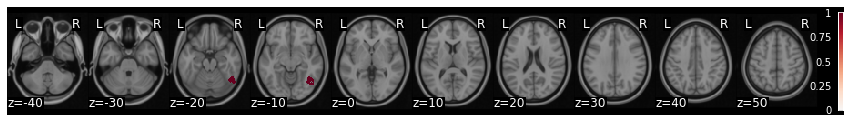

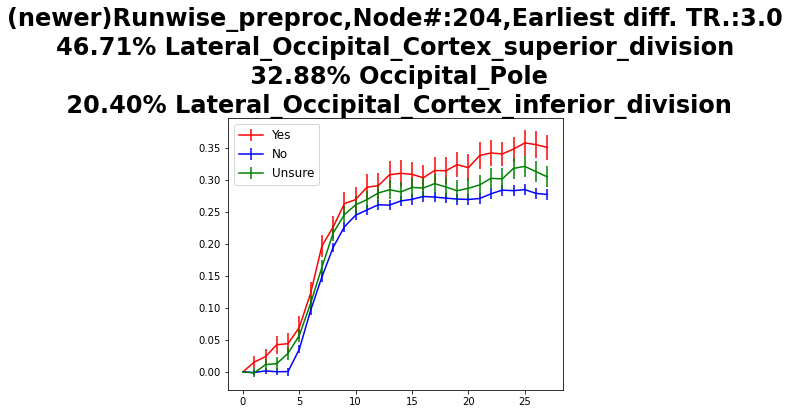

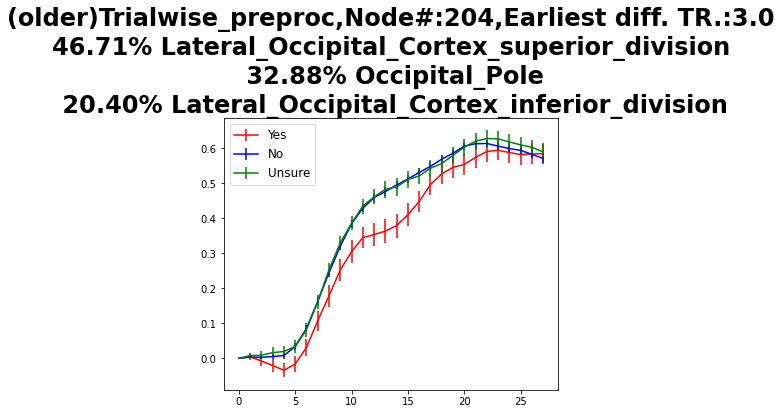

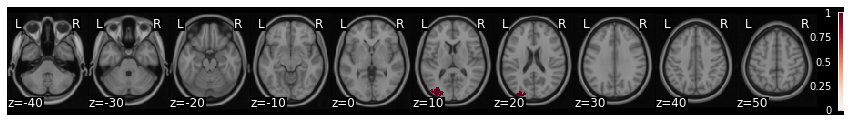

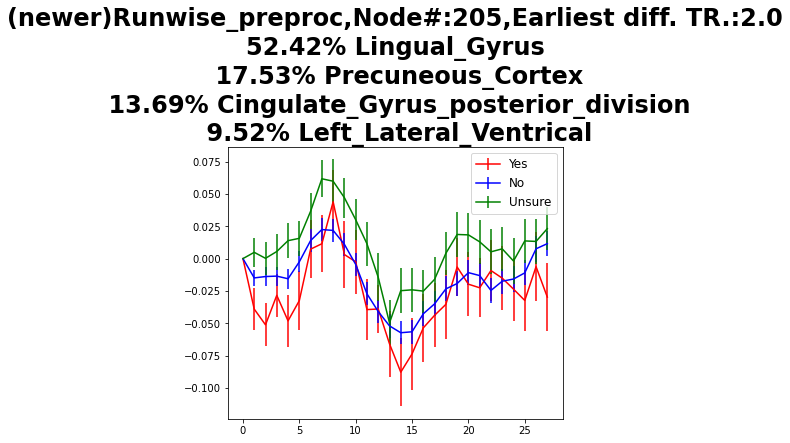

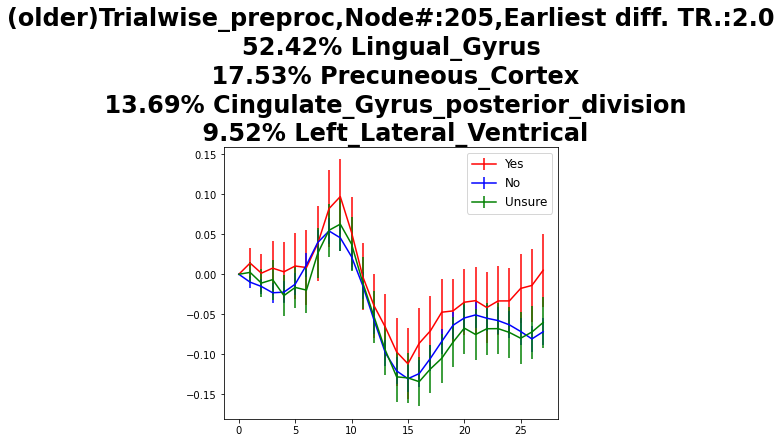

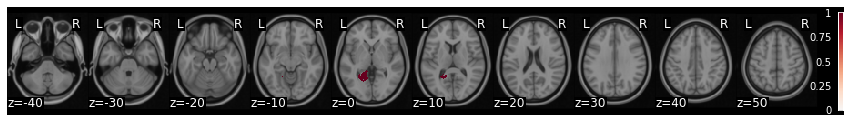

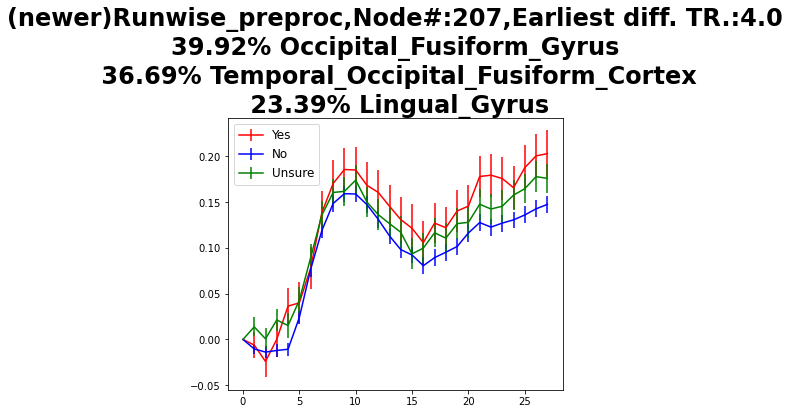

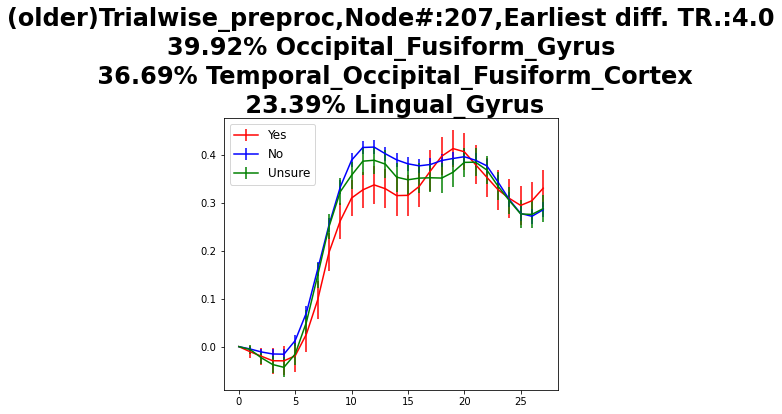

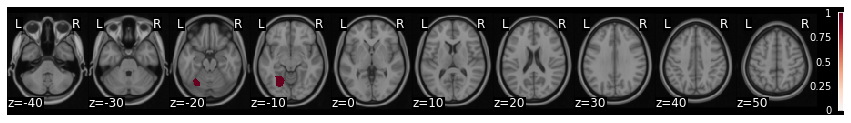

In [91]:
print('plotting more nodes..\n')
print('Node nr. 1-indexed')

#plt.figure(1,figsize = (20,25))

for i,node_ind in enumerate(nodes):
    #plt.subplot(6,2,i+1)
    #node_ind = 75
    movie_ind=4
    dict = eval(shen268[str(node_ind +1)][0])
    nodename =dict['name']
    nodename = nodename.split(';')
    nodename = "\n".join(nodename)
    #print(nodename,'\n-----')


    plt.figure(i*3+1,figsize = (6,5))
    plt.errorbar(range(28),np.nanmean(movie_tc_yes[:,node_ind,:,movie_ind],axis=0),
                 stats.sem(movie_tc_yes[:,node_ind,:,movie_ind],axis=0,nan_policy='omit'),
                 color = 'r', label = 'Yes')
    plt.errorbar(range(28),np.nanmean(movie_tc_no[:,node_ind,:,movie_ind],axis=0),
                 stats.sem(movie_tc_no[:,node_ind,:,movie_ind],axis=0,nan_policy='omit')
                 ,color ='b', label = 'No')
    plt.errorbar(range(28),np.nanmean(movie_tc_unsure[:,node_ind,:,movie_ind],axis=0),
                 stats.sem(movie_tc_unsure[:,node_ind,:,movie_ind],axis=0,nan_policy='omit')
                 ,color ='g', label = 'Unsure')

    title_str = f"(newer)Runwise_preproc,Node#:{node_ind+1},Earliest diff. TR.:{np.abs(timepts_signed[i])}\n{nodename}"
    plt.title(title_str, fontsize = 24,fontweight = 'bold')
    plt.legend(fontsize = 12)
    
    plt.figure(i*3+2,figsize = (6,5))
    plt.errorbar(range(28),np.nanmean(movie_tc_yes_trialwise[:,node_ind,:,movie_ind],axis=0),
                 stats.sem(movie_tc_yes_trialwise[:,node_ind,:,movie_ind],axis=0,nan_policy='omit'),
                 color = 'r', label = 'Yes')
    plt.errorbar(range(28),np.nanmean(movie_tc_no_trialwise[:,node_ind,:,movie_ind],axis=0),
                 stats.sem(movie_tc_no_trialwise[:,node_ind,:,movie_ind],axis=0,nan_policy='omit')
                 ,color ='b', label = 'No')
    plt.errorbar(range(28),np.nanmean(movie_tc_unsure_trialwise[:,node_ind,:,movie_ind],axis=0),
                 stats.sem(movie_tc_unsure_trialwise[:,node_ind,:,movie_ind],axis=0,nan_policy='omit')
                 ,color ='g', label = 'Unsure')

    title_str = f"(older)Trialwise_preproc,Node#:{node_ind+1},Earliest diff. TR.:{np.abs(timepts_signed[i])}\n{nodename}"
    plt.title(title_str, fontsize = 24,fontweight = 'bold')
    plt.legend(fontsize = 12)

    #plt.tight_layout()

    mat = np.zeros((268,))
    mat[node_ind] = 1
    img = roi_to_brain(pd.Series(mat), mask_x) # plot max difference timepoint for each node
    # red/blue indicate whether yes>no or yes-no at that timept >0 or <0
    # intensity of red/blue indicate whether the activity was early or late 
    #(todo: change negative values in the colorbar)
    img.plot(colorbar=True, cmap = 'RdBu_r')




# Extra: General plotting and visualizations to draw out posterior nodes

## Exploring ROIs

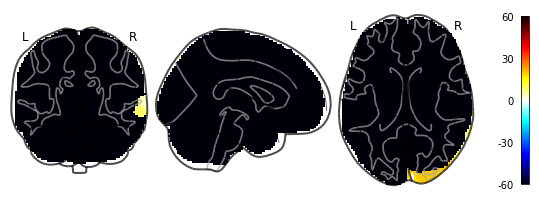

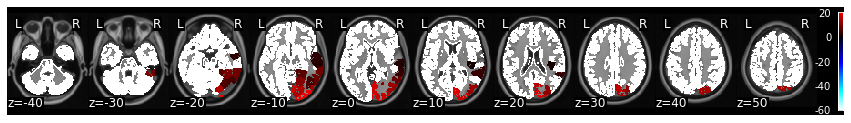

In [68]:
#Import brain plot libraries

from nilearn.plotting import plot_glass_brain
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)
vals = np.arange(0,268)
vals[vals>80] = 0
vals[vals<60] = 0
vals -= 60
img = roi_to_brain(pd.Series(vals), mask_x)
plot_glass_brain(img.to_nifti(), colorbar = True, plot_abs=False)#, cmap = 'Set1')
img.plot(colorbar=True,symmetric_cbar = False)


#from nilearn import plotting
#plotting.plot_stat_map(img.to_nifti())